# EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [ ]:
from utils import clear_text, get_doc_emb

In [ ]:
FILE_PATH = "bbc-text.csv"

column_name = {
    "text": "text",
    "label": "category"
}

In [4]:
data_df = pd.read_csv(FILE_PATH).sample(frac=1)
data_df.head()

,category,text
2134,sport,bell set for england debut bath prop duncan be...
1152,entertainment,housewives lift channel 4 ratings the debut of...
160,entertainment,goodrem wins top female mtv prize pop singer d...
2023,tech,humanoid robot learns how to run car-maker hon...
900,sport,kenteris denies faking road crash greek sprint...


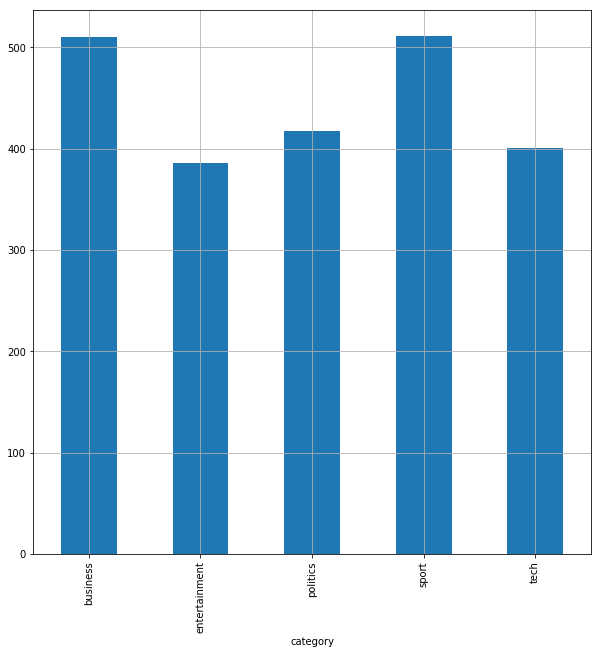

In [5]:
encoder = LabelEncoder()
data_df["category_enc"] = encoder.fit_transform(data_df["category"])
data_df.groupby('category').category.count().plot.bar(grid=True,figsize=(10, 10));

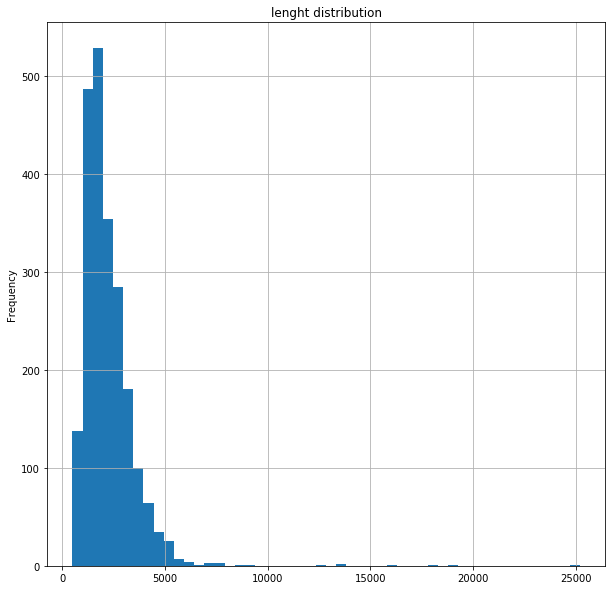

In [6]:
data_df[column_name["text"]] = clear_text(data_df["text"])

# number of chars
data_df[column_name["text"]].str.len().plot(kind="hist", title="lenght distribution", grid=True, figsize=(10,10), bins=50);
# data_df[column_name["text"]] = data_df[column_name["text"]].apply(lambda x: x[:5000])

# Encode text into GUSE embeddings

In [ ]:
import tensorflow_hub as hub

URL = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
emb_module = hub.Module(URL)

In [8]:
data = get_doc_emb(emb_module, data_df.text.values)
data.shape

W0827 11:41:37.462373 140656584218496 deprecation_wrapper.py:119] From /content/utils.py:29: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0827 11:41:37.580757 140656584218496 deprecation_wrapper.py:119] From /content/utils.py:30: The name tf.global_variables_initializer is deprecated. Please use tf.compat.v1.global_variables_initializer instead.

W0827 11:41:38.994112 140656584218496 deprecation_wrapper.py:119] From /content/utils.py:31: The name tf.tables_initializer is deprecated. Please use tf.compat.v1.tables_initializer instead.



(2225, 512)

# Principal Component Analysis

In [ ]:
from sklearn.decomposition import PCA

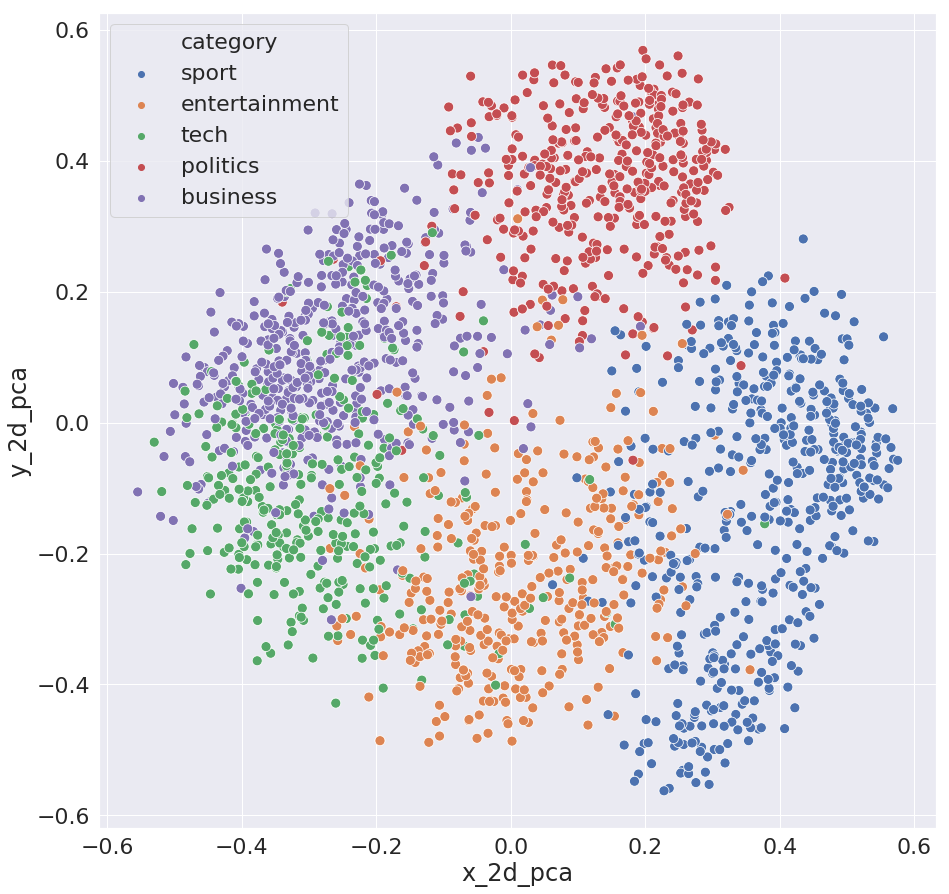

In [10]:
#reduce down to 2 dim
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

data_df["x_2d_pca"] = data_pca[:, 0]
data_df["y_2d_pca"] = data_pca[:, 1]

plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_pca",
    y="y_2d_pca",
    hue="category",
    data=data_df,
    s=100
);

# Principal Component Analysis + t-SNE

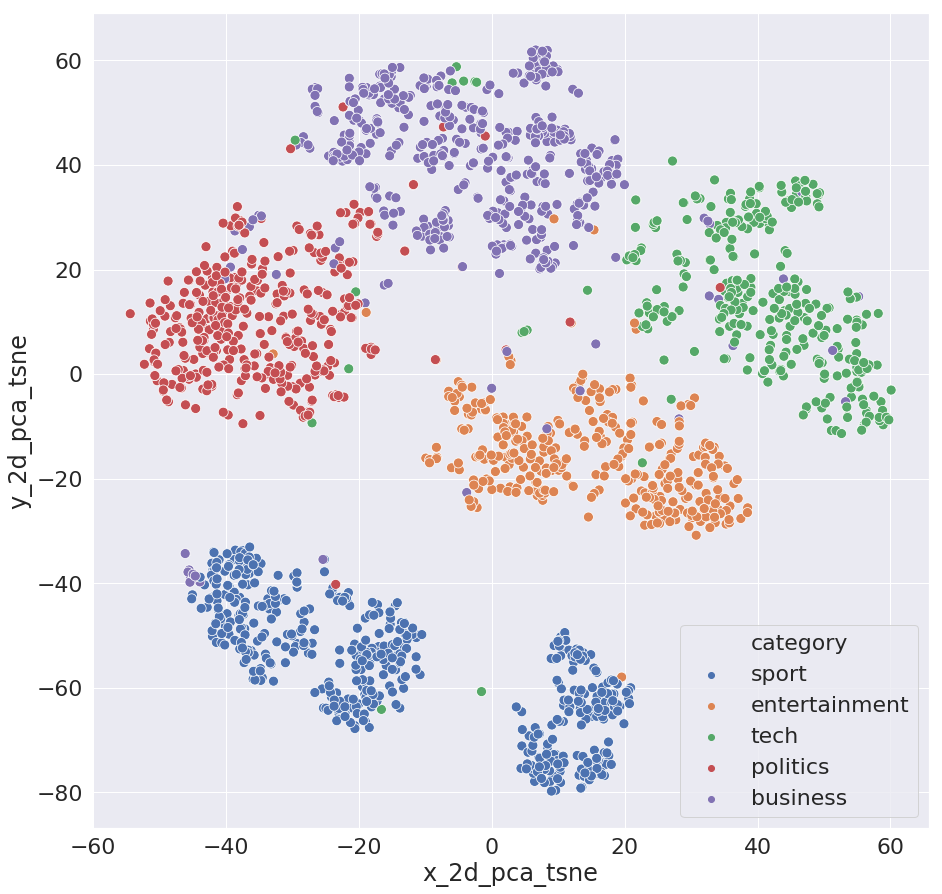

In [11]:
#reduce down to 50 dim
pca = PCA(n_components=50)
data_pca = pca.fit_transform(data)

#further reduce to 2 dim using t-SNE
data_pca_tsne = TSNE(n_components=2).fit_transform(data_pca)

data_df["x_2d_pca_tsne"] = data_pca_tsne[:, 0]
data_df["y_2d_pca_tsne"] = data_pca_tsne[:, 1]

plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_pca_tsne",
    y="y_2d_pca_tsne",
    hue="category",
    data=data_df,
    s=100
);

# Non Linear Probabilistic Component Analysis

In [ ]:
!pip3 install inferpy

In [ ]:
import inferpy as inf
import tensorflow as tf

In [ ]:
# number of components
n_comp = 2
# size of the hidden layer in the NN
hidden_dim = 10
# dimensionality of the data
data_dim = 512


def decoder(z, hidden_dim, data_dim):
    h = tf.layers.dense(inputs=z, units=hidden_dim, activation=tf.nn.relu)
    return tf.layers.dense(inputs=h, units=2*data_dim)


# model scheme
@inf.probmodel
def nlpca(n_comp, hidden_dim, data_dim, decoder):

    with inf.datamodel() as m:
        z = inf.Normal(loc=tf.ones([n_comp]) * 0.5, scale=1.0, name="z")# shape = [N, n_comp]
        output = decoder(z, hidden_dim, data_dim)
        x_loc = output[:, :data_dim]
        x_scale = tf.nn.softmax(output[:,data_dim:])
        x = inf.Normal(x_loc, x_scale, name="x")# shape = [N,d]

# inference
@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(initial_value=tf.ones([k]) * 0.5, name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(initial_value=tf.ones([k]), name="qz_scale"))

        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

In [15]:
model = nlpca(n_comp, hidden_dim, data_dim, decoder)

# set the inference algorithm
VI = inf.inference.VI(qmodel(n_comp), epochs=50000)

# learn the parameters
model.fit({"x": data}, VI)

W0827 11:42:52.621810 140656584218496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/util/tf_graph.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 11:42:52.950839 140656584218496 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/inferpy/models/random_variable.py:430: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

W0827 11:42:53.028255 140656584218496 deprecation.py:323] From <ipython-input-14-c1014c7afc1d>:9: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0827 11:42:53.039888 140656584218496 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be remov


 0 epochs	 1057296320.0....................
 200 epochs	 191190336.0....................
 400 epochs	 186614384.0....................
 600 epochs	 185537856.0....................
 800 epochs	 185018528.0....................
 1000 epochs	 184821184.0....................
 1200 epochs	 184612576.0....................
 1400 epochs	 184515968.0....................
 1600 epochs	 184399648.0....................
 1800 epochs	 184381552.0....................
 2000 epochs	 184294848.0....................
 2200 epochs	 184283200.0....................
 2400 epochs	 184278208.0....................
 2600 epochs	 184305760.0....................
 2800 epochs	 184309104.0....................
 3000 epochs	 184121232.0....................
 3200 epochs	 184049536.0....................
 3400 epochs	 183957232.0....................
 3600 epochs	 183607408.0....................
 3800 epochs	 183256528.0....................
 4000 epochs	 181931728.0....................
 4200 epochs	 181251232.0..............

In [ ]:
#extract the hidden representation
hidden_encoding = model.posterior("z")
data_nlpca = hidden_encoding.sample()

data_df["x_2d_nlpca"] = data_nlpca[:, 0]
data_df["y_2d_nlpca"] = data_nlpca[:, 1]

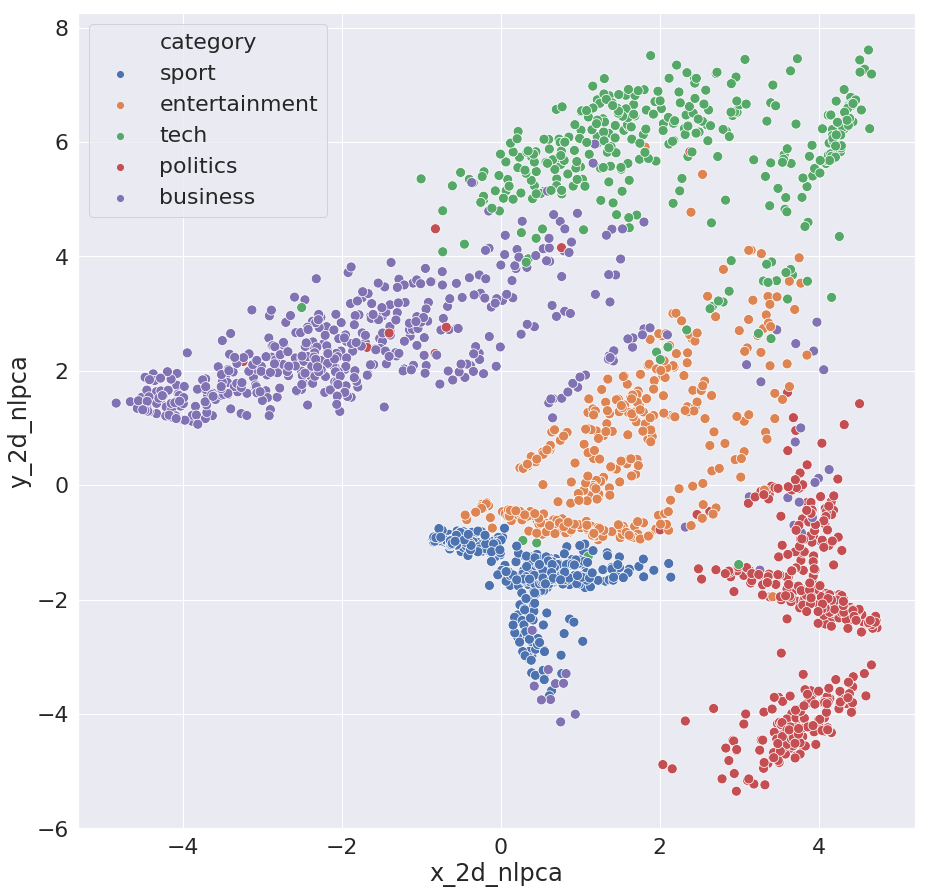

In [17]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_nlpca",
    y="y_2d_nlpca",
    hue="category",
    data=data_df,
    s=100
);

# Non Linear Probabilistic Component Analysis + t-SNE

In [ ]:
# number of components
n_comp = 50
# size of the hidden layer in the NN
hidden_dim = 10
# dimensionality of the data
data_dim = 512


def decoder(z, hidden_dim, data_dim):
    h = tf.layers.dense(inputs=z, units=hidden_dim, activation=tf.nn.relu)
    return tf.layers.dense(inputs=h, units=2*data_dim)


# model scheme
@inf.probmodel
def nlpca(n_comp, hidden_dim, data_dim, decoder):

    with inf.datamodel() as m:
        z = inf.Normal(loc=tf.ones([n_comp]) * 0.5, scale=1.0, name="z")# shape = [N, n_comp]
        output = decoder(z, hidden_dim, data_dim)
        x_loc = output[:, :data_dim]
        x_scale = tf.nn.softmax(output[:,data_dim:])
        x = inf.Normal(x_loc, x_scale, name="x")# shape = [N,d]

# inference
@inf.probmodel
def qmodel(k):
    with inf.datamodel():
        qz_loc = inf.Parameter(initial_value=tf.ones([k]) * 0.5, name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(initial_value=tf.ones([k]), name="qz_scale"))

        qz = inf.Normal(loc=qz_loc, scale=qz_scale, name="z")

In [19]:
model = nlpca(n_comp, hidden_dim, data_dim, decoder)

# set the inference algorithm
VI = inf.inference.VI(qmodel(n_comp), epochs=50000)

# learn the parameters
model.fit({"x": data}, VI)


 0 epochs	 5459287040.0....................
 200 epochs	 210441888.0....................
 400 epochs	 192035728.0....................
 600 epochs	 188640720.0....................
 800 epochs	 187193216.0....................
 1000 epochs	 186391920.0....................
 1200 epochs	 185819552.0....................
 1400 epochs	 185519232.0....................
 1600 epochs	 185210480.0....................
 1800 epochs	 185000528.0....................
 2000 epochs	 184821120.0....................
 2200 epochs	 184712304.0....................
 2400 epochs	 184636368.0....................
 2600 epochs	 184595360.0....................
 2800 epochs	 184509440.0....................
 3000 epochs	 184518112.0....................
 3200 epochs	 184434592.0....................
 3400 epochs	 184378256.0....................
 3600 epochs	 184275600.0....................
 3800 epochs	 184253904.0....................
 4000 epochs	 183083776.0....................
 4200 epochs	 182383728.0..............

In [ ]:
#extract the hidden representation
hidden_encoding = model.posterior("z")
data_nlpca = hidden_encoding.sample()

#further reduce to 2 dim using t-SNE
data_nlpca_tsne = TSNE(n_components=2).fit_transform(data_nlpca)
data_df["x_2d_nlpca_tsne"] = data_nlpca_tsne[:, 0]
data_df["y_2d_nlpca_tsne"] = data_nlpca_tsne[:, 1]

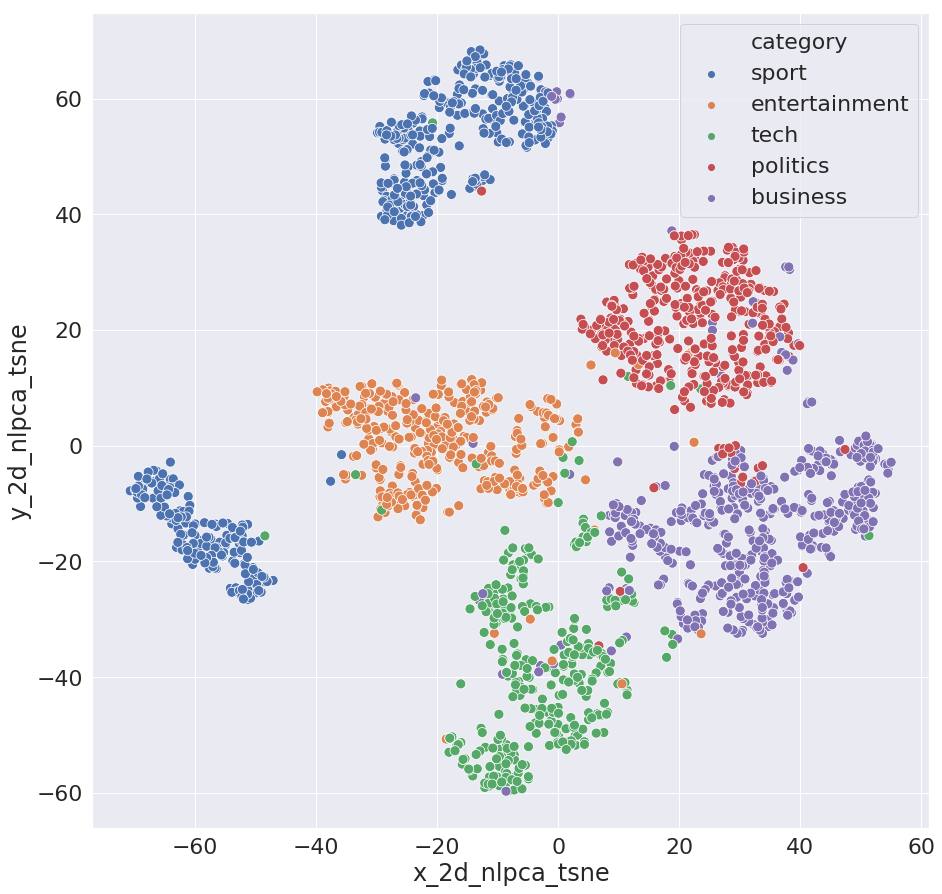

In [21]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.scatterplot(
    x="x_2d_nlpca_tsne",
    y="y_2d_nlpca_tsne",
    hue="category",
    data=data_df,
    s=100
);

# Baseline

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, data_df.category_enc.values, test_size=0.20, random_state=42, stratify=data_df.category_enc)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [ ]:
from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError, ClassificationReport
from sklearn.metrics import log_loss

label_encoder = dict(enumerate(encoder.classes_))
classes = list(label_encoder.values())

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rf_clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
y_pred = rf_clf.predict_proba(x_test)
print("Accuracy {:.4f} and Cross-Entropy Loss {:.4f} for test data".format(rf_clf.score(x_test, y_test), log_loss(y_test, y_pred)))

Accuracy 0.9506 and Cross-Entropy Loss 0.3068 for test data


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


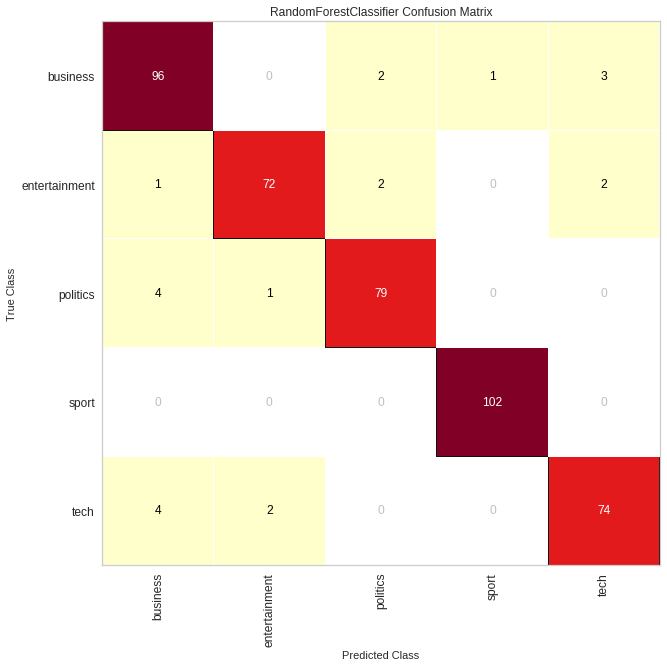

In [27]:
plt.figure(figsize=(10, 10))
visualizer = ConfusionMatrix(rf_clf, classes=classes, label_encoder=label_encoder)
visualizer.score(x_test, y_test)
visualizer.poof()

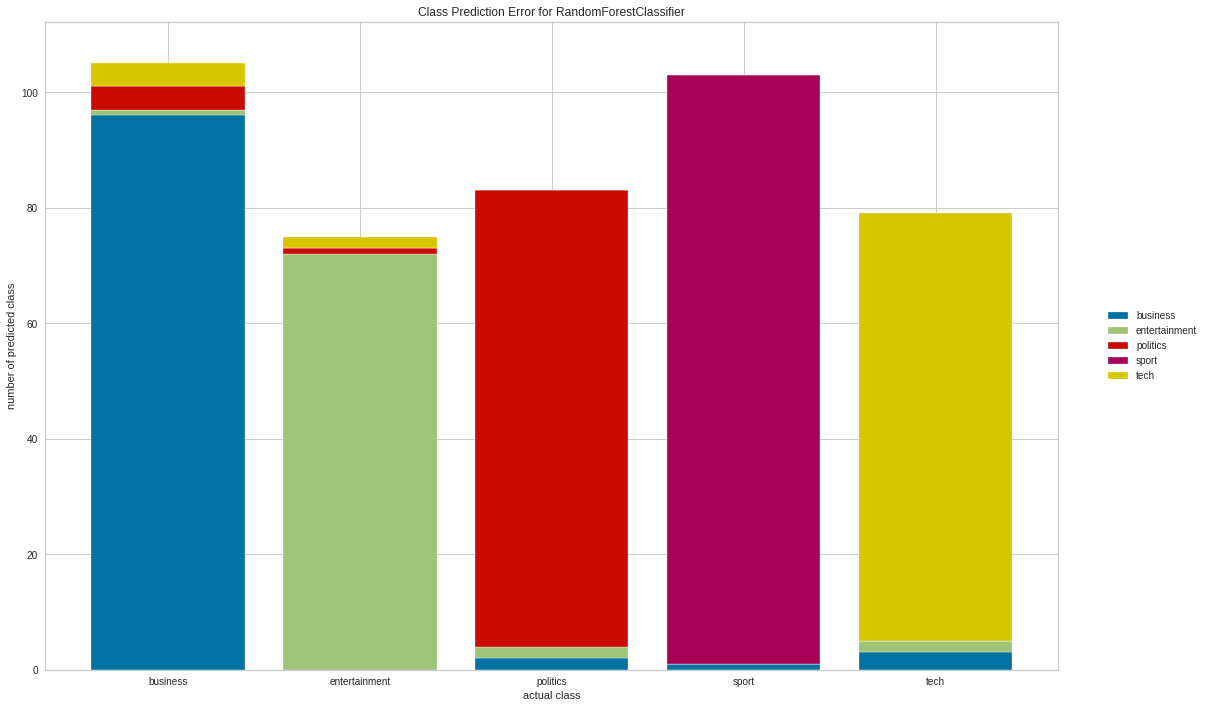

In [28]:
plt.figure(figsize=(20,10))
visualizer = ClassPredictionError(
    model=rf_clf, classes=classes
)

visualizer.score(x_test, y_test)
visualizer.poof()

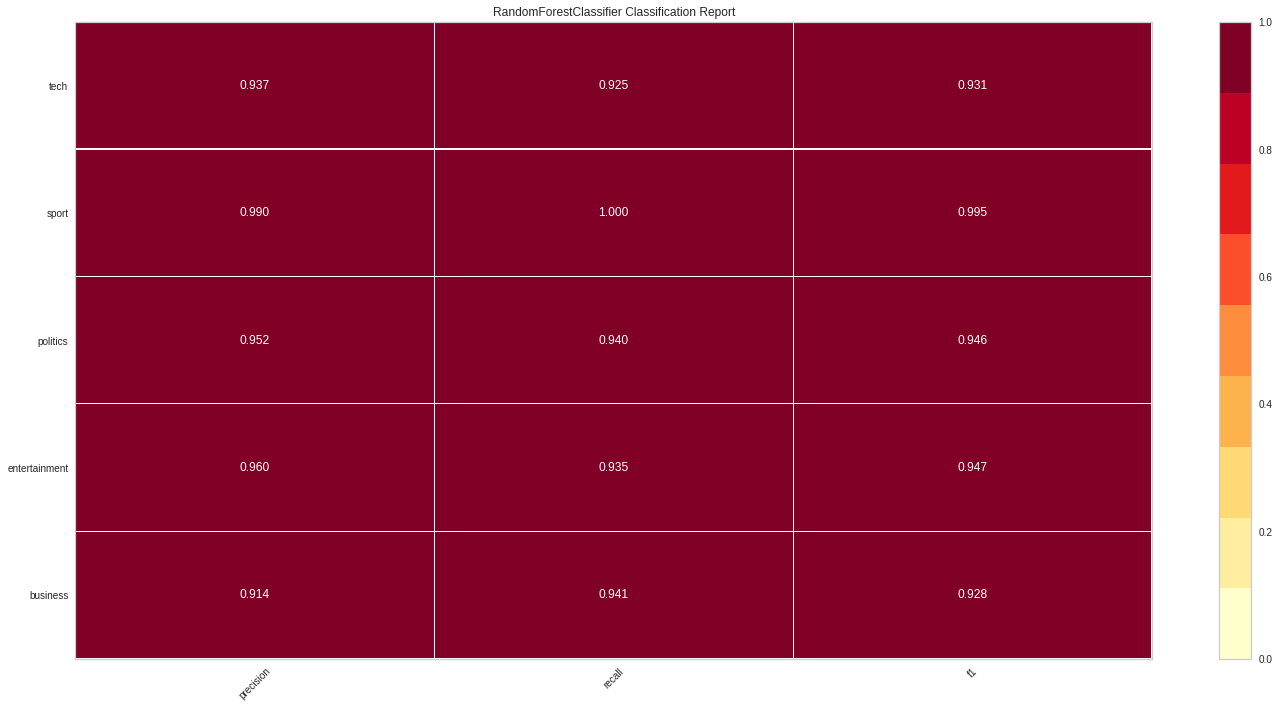

In [29]:
plt.figure(figsize=(20,10))
visualizer = ClassificationReport(model=rf_clf, classes=classes)
visualizer.score(x_test, y_test)
visualizer.poof()

## Random Forest Classifier CV Approach

In [ ]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import seaborn as sns

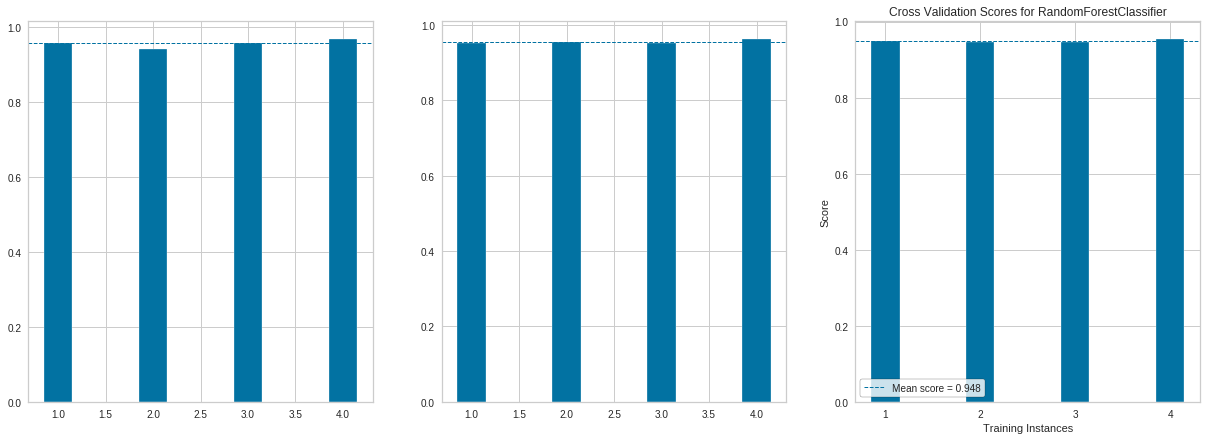

In [32]:
rf_clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5)

cv = StratifiedKFold(n_splits=4)
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

for i, scoring in enumerate(['f1_weighted', 'recall_weighted', 'precision_weighted']):
    oz = CVScores(
        rf_clf, ax=ax[i], cv=cv, scoring=scoring
    )

    oz.fit(data, data_df.category_enc.values)

oz.poof()


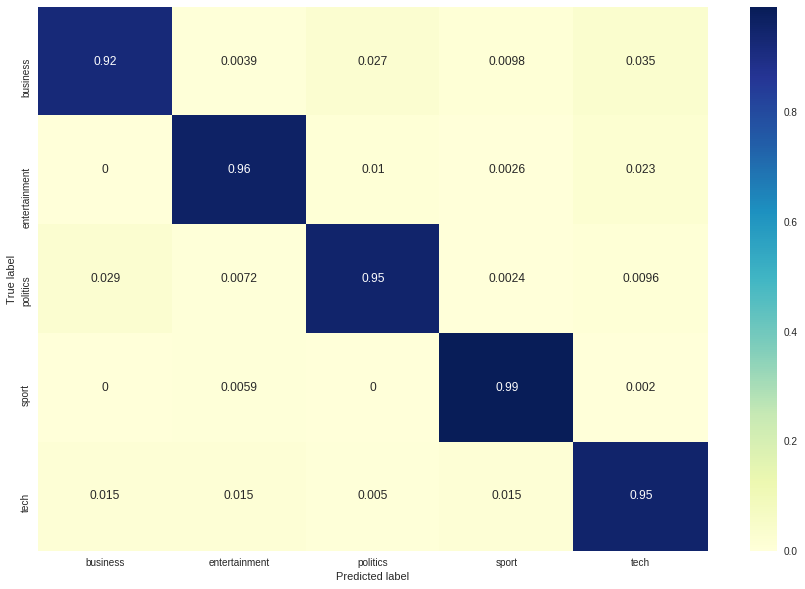

In [48]:
rf_clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5)
y_pred = cross_val_predict(rf_clf, data, data_df.category_enc.values, cv=4)
conf_mat = confusion_matrix(data_df.category_enc.values, y_pred)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, cmap= "YlGnBu", xticklabels=classes, yticklabels=classes)
plt.ylabel('True label')
plt.xlabel('Predicted label');

## XGBoost  Classifier

In [ ]:
from xgboost import XGBClassifier

In [41]:
default_params = {
    "objective": "multi:softmax",
    "num_class": 5
}

xgb_clf = XGBClassifier()
xgb_clf.fit(X=x_train, y=y_train, eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=20, eval_metric=['merror', "mlogloss"])

[0]	validation_0-merror:0.056929	validation_0-mlogloss:1.41023	validation_1-merror:0.098876	validation_1-mlogloss:1.41955
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.035206	validation_0-mlogloss:1.2477	validation_1-merror:0.078652	validation_1-mlogloss:1.26833
[2]	validation_0-merror:0.028464	validation_0-mlogloss:1.11546	validation_1-merror:0.069663	validation_1-mlogloss:1.14156
[3]	validation_0-merror:0.024719	validation_0-mlogloss:1.00253	validation_1-merror:0.069663	validation_1-mlogloss:1.03283
[4]	validation_0-merror:0.023221	validation_0-mlogloss:0.905843	validation_1-merror:0.067416	validation_1-mlogloss:0.941462
[5]	validation_0-merror:0.020974	validation_0-mlogloss:0.820716	validation_1-merror:0.058427	validation_1-mlogloss:0.858735
[6]	validation_0-merror:0.016479	validation_0-mlogloss:0.745409	validation_1-merror:0.053933	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
y_pred = xgb_clf.predict_proba(x_test)
print("Accuracy {:.4f} and Cross-Entropy Loss {:.4f} for test data".format(xgb_clf.score(x_test, y_test), log_loss(y_test, y_pred)))

Accuracy 0.9685 and Cross-Entropy Loss 0.1081 for test data


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


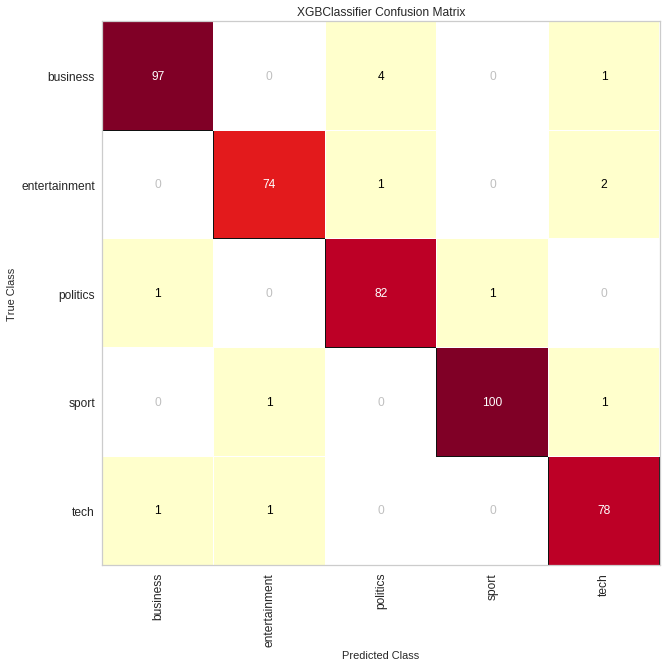

In [43]:
plt.figure(figsize=(10,10))
visualizer = ConfusionMatrix(xgb_clf, classes=classes, label_encoder=label_encoder)
visualizer.score(x_test, y_test)
visualizer.poof()

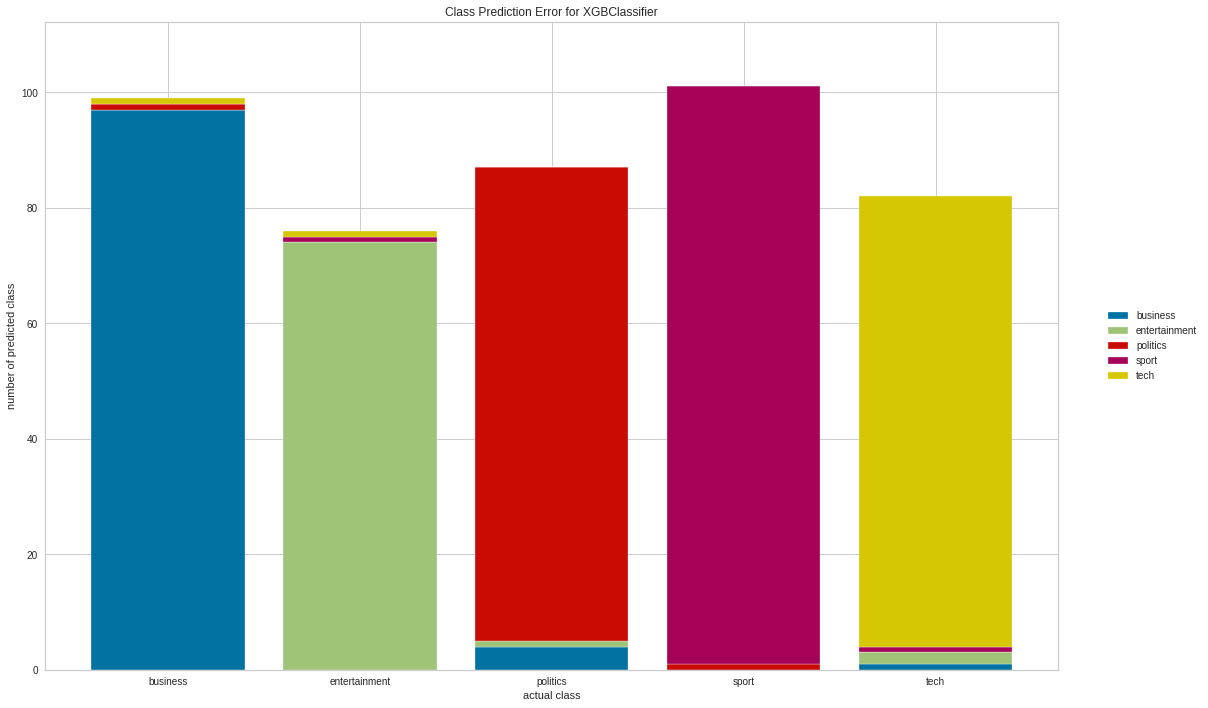

In [44]:
plt.figure(figsize=(20,10))
visualizer = ClassPredictionError(
    model=xgb_clf, classes=classes
)

visualizer.score(x_test, y_test)
visualizer.poof()

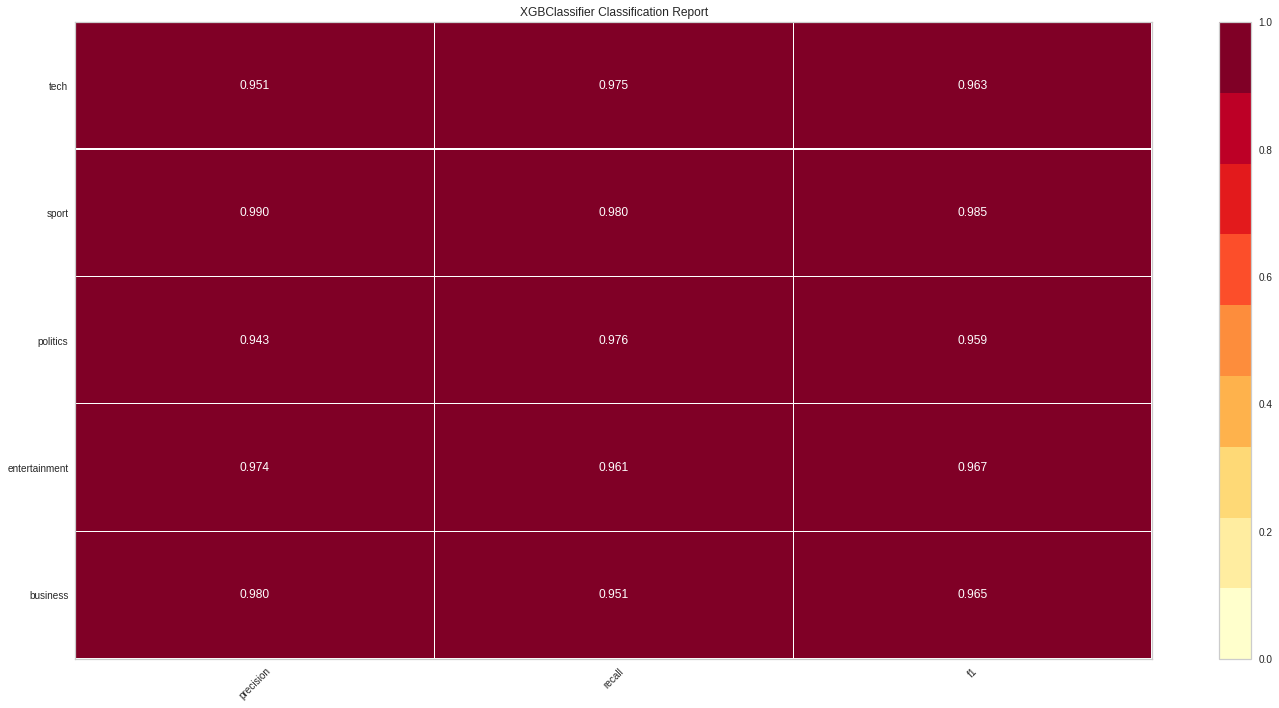

In [45]:
plt.figure(figsize=(20,10))
visualizer = ClassificationReport(model=xgb_clf, classes=classes)
visualizer.score(x_test, y_test)
visualizer.poof()